# ML project
TODO:
- More sophisticated graphs
- Test against other models

In [32]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from model_architecture import tft, training, val_dataloader, train_dataloader, validation

import matplotlib.pyplot as plt

In [33]:
# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

pl.seed_everything(42)

trainer = pl.Trainer(
    gpus=0,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

Global seed set to 42
/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [34]:
# Load the model
savedTft = TemporalFusionTransformer.load_from_checkpoint('./lightning_logs/version_36/checkpoints/epoch=20-step=630.ckpt')

/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [35]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)
#savedTft

/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 32.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 16.1 K

Sanity Checking: 0it [00:00, ?it/s]

/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/__init__.py", line 4, in <module>
    from pytorch_forecasting.data import (
  File "/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/__init__.py", line 7, in <module>
    from pytorch_forecasting.data.encoders import (
  File "/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/encoders.py", line 24, in <module>
    from pytorch_forecasting.utils impo

In [36]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# Previous best trained model: /Users/deividas/Workplace/Workforce_Scheduler_Workspace/demand-forecaster-sam/lightning_logs/version_36/checkpoints/epoch=20-step=630.ckpt

#best_model_path = trainer.checkpoint_callback.best_model_path
#print(best_model_path)
#best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# TODO: Uncomment when testing!
best_tft = savedTft # TODO: Comment out when retraining again

raw_prediction, x = best_tft.predict(
    training,
    mode="raw",
    return_x=True,
)

/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/models/base_model.py:92: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 63, 1, 540]). Returning list instead of torch.Tensor.
  warnings.warn(


In [ ]:
# Save the temporal fusion transformer model
torch.save(trainer.checkpoint_callback.best_model_path, './Saved_Models/40MinsTrain_105k_params.pth')
!zip  -r model.zip ./lightning_logs/version_36/*

In [13]:
# Extract the actual target values from val_dataloader
actual_target = []
for batch in val_dataloader:
    actual_target.append(batch[1])

# Flatten the list
actual_target = [item for sublist in actual_target for item in sublist]
actual_target

[[tensor([[52., 61., 66.,  ...,  1.,  0., 48.],
          [61., 66., 44.,  ...,  0., 48., 68.],
          [66., 44., 36.,  ..., 48., 68., 94.],
          ...,
          [32., 39., 66.,  ..., 43., 44.,  6.],
          [32., 39., 66.,  ..., 43., 44.,  6.],
          [32., 39., 66.,  ..., 43., 44.,  6.]]),
  tensor([[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]),
  tensor([[3., 3., 3.,  ..., 3., 4., 4.],
          [3., 3., 3.,  ..., 4., 4., 4.],
          [3., 3., 3.,  ..., 4., 4., 4.],
          ...,
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.],
          [4., 4., 4.,  ..., 4., 4., 4.]]),
  tensor([[4., 4., 4.,  ..., 4., 5., 5.],
          [4., 4., 4.,  ..., 5., 5., 5.],
          [4., 4., 4.,  ..., 5., 5., 5.],
          ...,
          [5., 5

Predict:   0%|          | 0/5 [00:00<?, ? batches/s]

/Users/deividas/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/models/base_model.py:92: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([128, 63, 1, 540]). Returning list instead of torch.Tensor.
  warnings.warn(


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

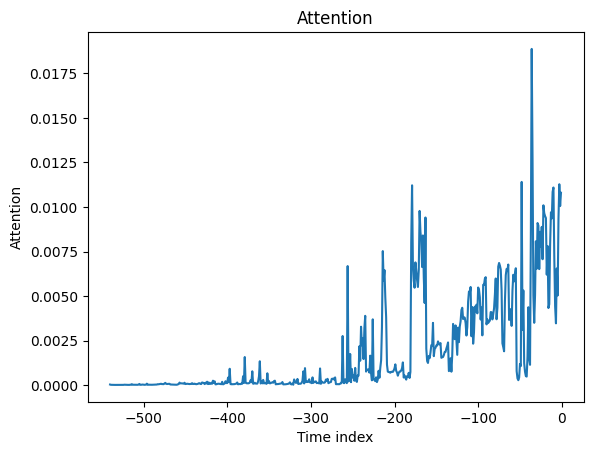

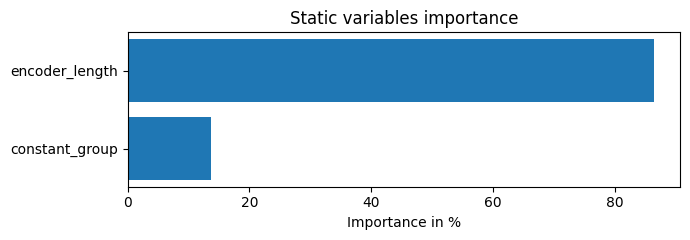

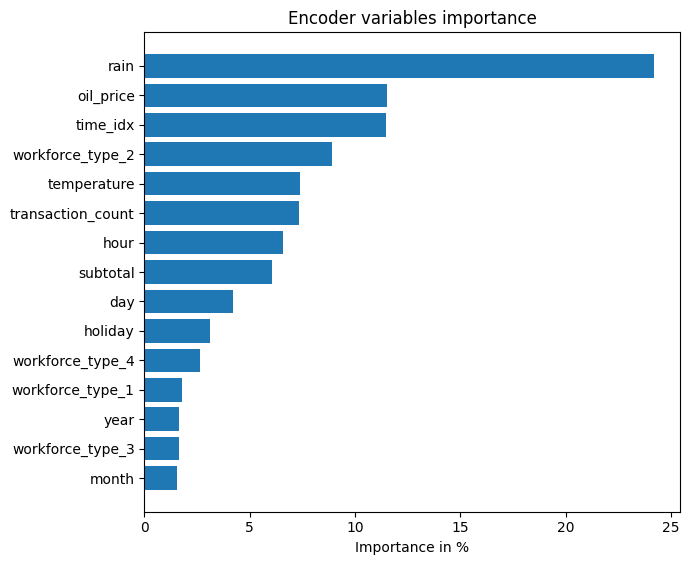

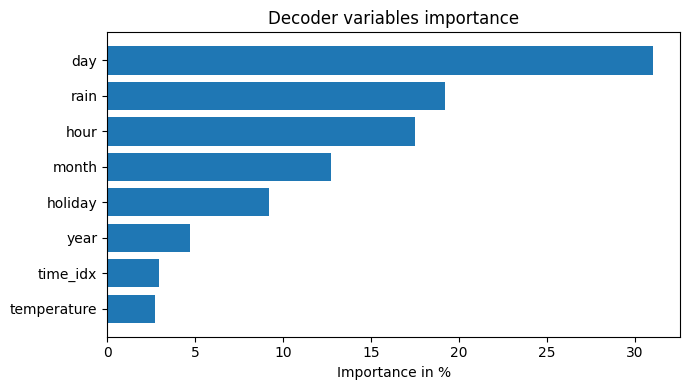

In [14]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True, show_progress_bar=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

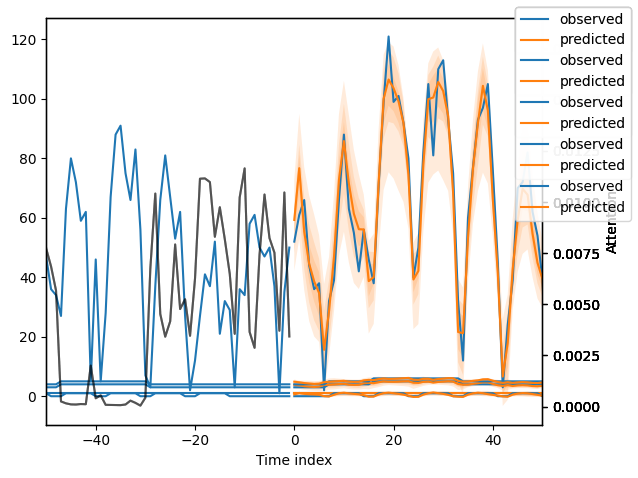

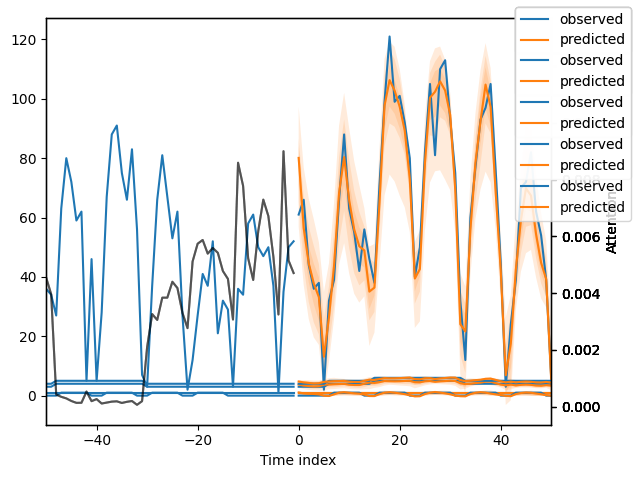

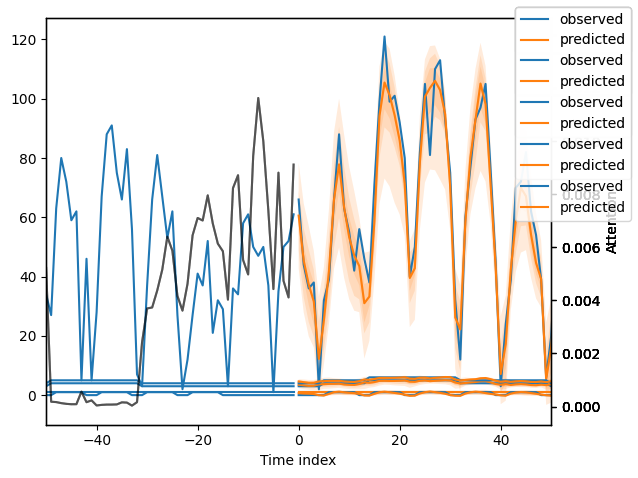

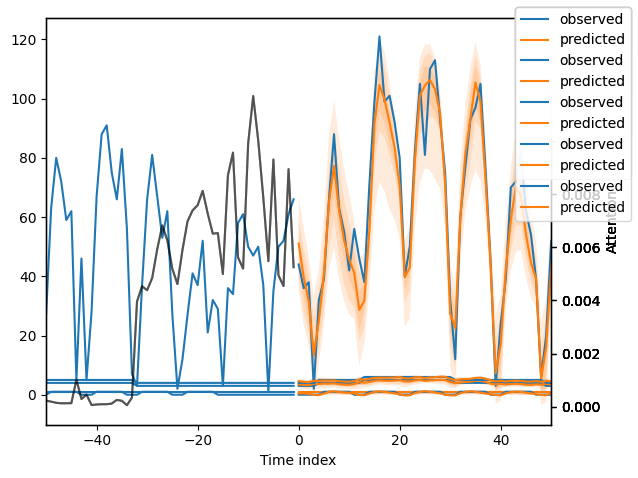

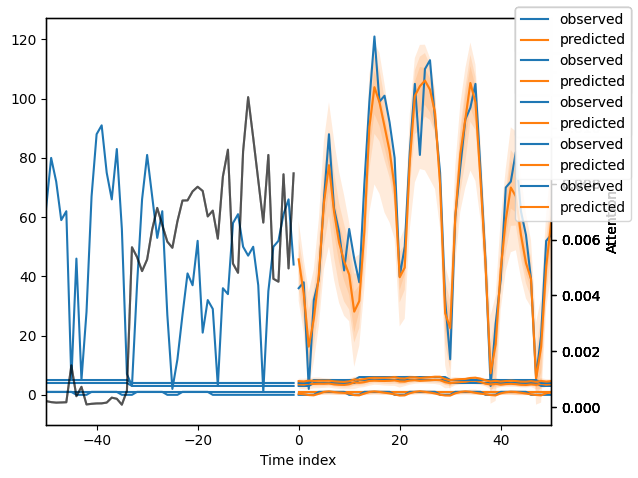

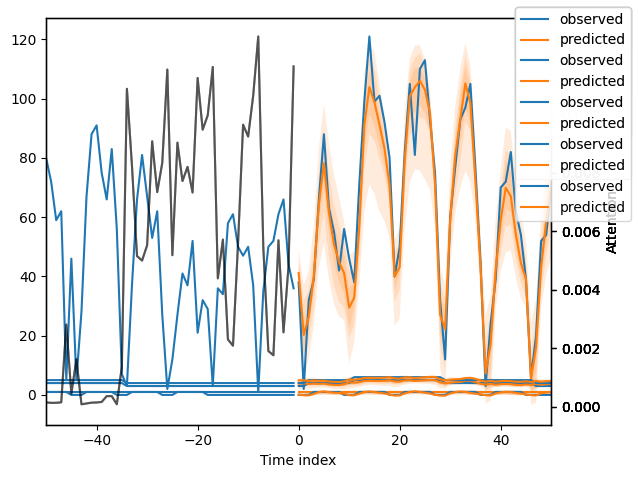

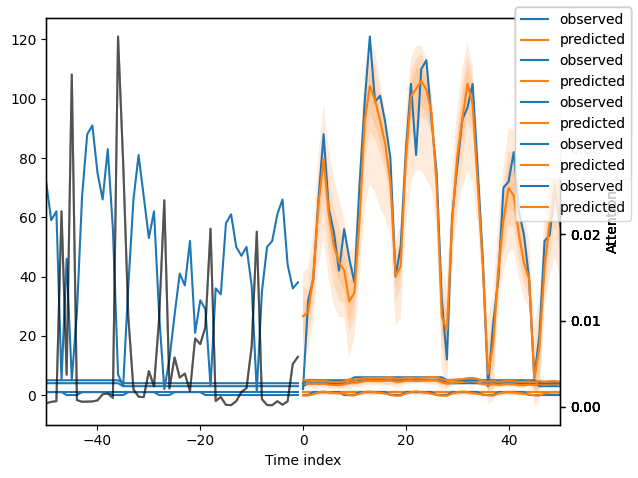

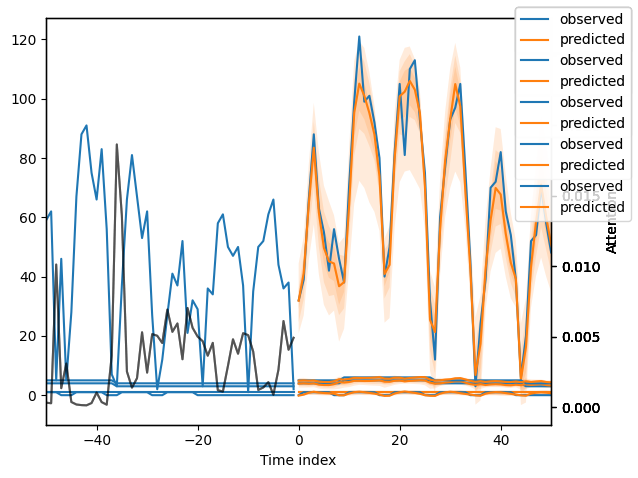

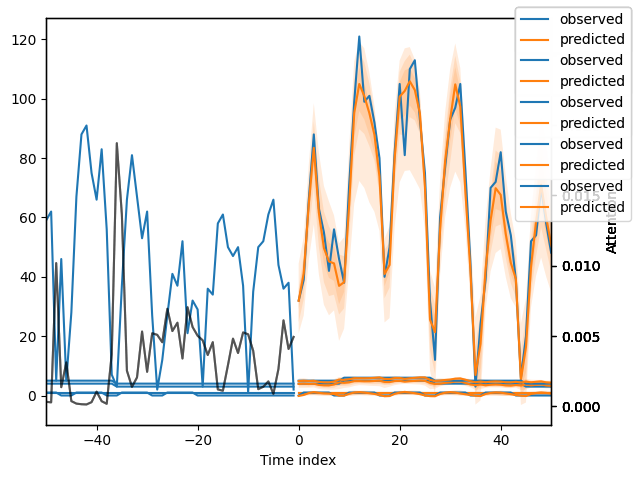

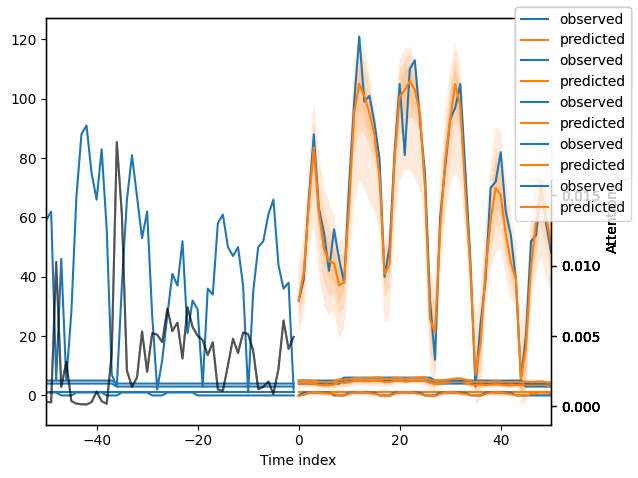

In [19]:

for idx in range(10): 
    best_tft.plot_prediction(x, raw_predictions, idx=idx)
    # plt.show only the first 200 samples
    plt.xlim(-50, 50)
    plt.show()




In [23]:


# Fix this error from the below code: TypeError: only integer tensors of a single element can be converted to an index
predictions, x = best_tft.predict(val_dataloader, return_x=True)

predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable

#predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions, )
#best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

TypeError: only integer tensors of a single element can be converted to an index

In [31]:
predictions.shape()

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
x.keys()
#x['decoder_target']
raw_predictions.keys()
#raw_prediction["prediction"]



In [ ]:
# calculate mean absolute error on validation set -> Done for transaction_count since there is much more variability in it. Could we include the other metrics as well? such as workforce_demands 
#actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
actuals = x['decoder_target'][0]


#predictions = best_tft.predict(val_dataloader)
predictions = raw_predictions["prediction"][0]

(actuals - predictions).abs().mean().item()

In [ ]:
raw_predictions["prediction"][0].shape

#x["decoder_target"][0].shape